## Simulation of Murdock and Okada (1970)
We start by comparing how our prototype- and instance-based implementations of CMR account for behavior in a classic experiment where each item is presented just once per study phase. For these simulations, we used the dataset reported by @murdock1970interresponse. Each of 72 undergraduates performed 20 trials with study lists each consisting of 20 unique words visually presented at either 60 or 120 words per minute. Given a particular subject, words were unique both within and across trials, and randomly selected from the Toronto Word Pool [@friendly1982toronto], a widely-used collection of high frequency nouns, adjectives, and verbs.

While the major focus of the original report by @murdock1970interresponse was to investigate inter-response times in single-trial free recall, here we focus consideration on the content of recorded recall sequences. Because it excludes within-list repetitions of studied items, this dataset presents the opportunity to compare model performance under simplified conditions. Since items' feature representations are assumed orthogonal under considered variants of CMR, retrieving a pattern of contextual associations given an item-based cue only requires abstraction over the cued item's pre-experimental and single experimental contextual associations. Interpretation of apparent differences in performance across model variants thus focus primarily on mechanisms for context-based item representation retrieval.

In [1]:
#| code-summary: code -- load dependencies and data

from compmemlearn.fitting import murdock_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR, Instance_CMR
from compmemlearn.datasets import prepare_murdock1970_data, simulate_data
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('data/mo1970.txt')

We compared the original prototype-based implementation of CMR against our novel instance-based implementation. First we evaluated each model variant based on their ability to predict the specific sequences of recalls exhibited by each participant. Considering all 20 trials performed by each participant in the dataset, we applied the differential evolution optimization technique to find for each model the parameter configuration that maximized the likelihood of recorded recall sequences. We obtained a unique optimal parameter configuration for each unique participant and each considered model variant. To measure the goodness-of-fit for each parameter configuration and corresponding model, [Figure @fig-MurdOkaFits] plots the log-likelihood of each participant's recall sequences given each model variant's corresponding optimized parameter configuration. The distribution of log-likelihood scores between participants for the PrototypeCMR and InstanceCMR model variants only marginally differ, suggesting little meaningful difference between variants in their effectiveness accounting for participant recall performance across the dataset.

In [2]:
#| code-summary: code -- 1) fit PrototypeCMR participant-by-participant
#| output: false

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count]]), 
        List([murd_length0]),
        init_cmr,
        {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        cmr_free_parameters)

    cmr_results.append(differential_evolution(cost_function, cmr_bounds, disp=False))
    print(cmr_results[-1].fun)

0 0
288.4608343921062
1 20
244.3214405839944
2 40
334.6185000195265
3 60
338.18753169606146
4 80
329.43414701322854
5 100
303.3731844430077
6 120
262.50093077184636
7 140
287.29487538369114
8 160
232.88863016852216
9 180
349.8561647751068
10 200
184.76488343111205
11 220
314.4756845916989
12 240
370.0329268635148
13 260
269.11623131561817
14 280
286.1572834494447
15 300
337.3588258033547
16 320
311.79735692879973
17 340
284.5416394341475
18 360
390.64575195233704
19 380
383.10955557235934
20 400
313.01741088915986
21 420
315.66590837629485
22 440
386.12566018141183
23 460
297.7221464826458
24 480
268.51912719844313
25 500
372.00144679098787
26 520
328.2551918115642
27 540
289.7522945774654
28 560
346.9682309536272
29 580
299.805909732255
30 600
341.232938865035
31 620
299.87121128434006
32 640
336.62921690919234
33 660
379.59520748549966
34 680
308.1779834916683
35 700
386.6227588207818
36 720
291.8588867950575
37 740
296.8623234193805
38 760
237.77254713713268
39 780
234.5450218813135

In [3]:
#| code-summary: code -- 2) fit InstanceCMR participant-by-participant
#| output: false

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
    'delay_drift_rate',
)

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Instance_CMR(item_count, presentation_count, parameters)

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
icmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
    List([murd_trials0[start_index:start_index+subject_trial_count]]),  
    List([murd_length0]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

    icmr_results.append(differential_evolution(cost_function, icmr_bounds, disp=False))
    print(icmr_results[-1].fun)

0 0
303.3179979935632
1 20
237.07475551981403
2 40
326.91145011152145
3 60
338.12840337243364
4 80
342.2569823151057
5 100
301.1883359074233
6 120
258.75285669581245
7 140
287.96456406689015
8 160
231.86789710894737
9 180
356.78081115657625
10 200
186.02850315074838
11 220
313.7100950562385
12 240
374.5455182131817
13 260
267.5367190628348
14 280
288.20915468969804
15 300
335.0511918402748
16 320
312.425708439102
17 340
297.8647803263724
18 360
388.04737222365713
19 380
384.0616810240237
20 400
312.05342097252543
21 420
330.2185266771611
22 440
383.9769309334116
23 460
298.37356527378336
24 480
272.7793788775146
25 500
367.22350937714486
26 520
325.1435008505373
27 540
330.2056154722019
28 560
351.4787667418721
29 580
302.71039961740115
30 600
373.5059897941029
31 620
307.05277253475435
32 640
345.93320516632934
33 660
380.3046106117535
34 680
313.2162014945306
35 700
387.90016536158663
36 720
295.95505282785683
37 740
298.60944535852224
38 760
239.41088019211344
39 780
236.06998339365

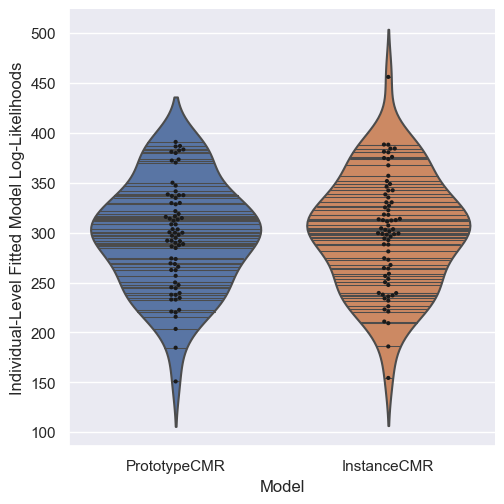

In [4]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')

individual_fits = [result.fun for result in cmr_results] + [result.fun for result in icmr_results]
labels = ['PrototypeCMR'] * len(cmr_results) + ['InstanceCMR'] * len(icmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('figures/individual_murdock1970.pdf', bbox_inches="tight")

summary_table = pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown()

In [5]:
#| code-summary: display markdown rendering of summary table
#| output: false

print(summary_table)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |       72      |        72      |
| mean  |      300.079  |       296.049  |
| std   |       56.0244 |        52.8994 |
| min   |      154.515  |       151.021  |
| 25%   |      258.204  |       260.956  |
| 50%   |      301.949  |       298.764  |
| 75%   |      335.82   |       330.849  |
| max   |      455.693  |       390.646  |


::: {#fig-murdokafits layout-nrow=2 layout-valign="center"}

![](figures/individual_murdock1970.pdf)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |        72     |         72     |
| mean  |      297.128   |       296.249  |
| std   |       52.7989 |        52.8859 |
| min   |      156.753 |        150.988 |
| 25%   |     258.206  |       260.956  |
| 50%   |     299.741  |       299.763  |
| 75%   |      331.797  |       331.946  |
| max   |     387.742  |       390.806  |

Distribution of log-likelihood scores of recall sequences exhibited by each subject under each considered model across list-lengths [@murdock1970interresponse]
:::



As a follow-up, we also compared how readily each model could account for organizational summary statistics in the dataset. We found for each model variant the optimal parameter configuration maximizing the likelihood of the entire dataset rather than participant-by-participant. Using each fitted model variant, we simulated 1000 unique free recall trials and measured summary statistics from the result. [Figure @fig-MurdOkaSummary] plots for each model against the corresponding statistics collected over the dataset how recall probability varies as a function of serial position, how the probability of recalling an item first varies as a function of serial position, and how the conditional recall probabability of an item varies as a function of its serial lag from the previously recalled item. Recapitulating our comparison of log-likelihood distributions fitted over discrete participants, we found that both our prototype-based and instance-based CMR implementations account for these benchmark organizational summary statistics across the full dataset to similar extents. To build on this finding of broad model equivalence with respect to the results reported by @murdock1970interresponse, we consider the model variants under broader experimental conditions.

In [6]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

differential_evolution step 1: f(x)= 27005.2
differential_evolution step 2: f(x)= 26474.5
differential_evolution step 3: f(x)= 26474.5
differential_evolution step 4: f(x)= 26216.5
differential_evolution step 5: f(x)= 26216.5
differential_evolution step 6: f(x)= 26213.7
differential_evolution step 7: f(x)= 26213.7
differential_evolution step 8: f(x)= 24884.4
differential_evolution step 9: f(x)= 24884.4
differential_evolution step 10: f(x)= 24246.6
differential_evolution step 11: f(x)= 23398.3
differential_evolution step 12: f(x)= 23398.3
differential_evolution step 13: f(x)= 23398.3
differential_evolution step 14: f(x)= 23330.9
differential_evolution step 15: f(x)= 23330.9
differential_evolution step 16: f(x)= 23330.9
differential_evolution step 17: f(x)= 23330.9
differential_evolution step 18: f(x)= 23330.9
differential_evolution step 19: f(x)= 23277.8
differential_evolution step 20: f(x)= 23277.8
differential_evolution step 21: f(x)= 23229.1
differential_evolution step 22: f(x)= 23229

In [7]:
#| include: false
print(cmr_result)

     fun: 22720.622653808452
     jac: array([  1.78006302,   8.65475158,   0.23828761,  -1.29475665,
         0.11095835,  -0.25138434,  -0.27757776,   0.        ,
       -10.97505446,  -2.64590199,  -1.45446381,   6.02740326])
 message: 'Optimization terminated successfully.'
    nfev: 8137
     nit: 32
 success: True
       x: array([5.75483865e-01, 4.05786123e-03, 7.29197365e-01, 6.91750520e-01,
       9.99976274e-01, 9.58929971e-02, 9.47040116e+00, 4.13963855e+01,
       3.13847947e-02, 3.36744953e-01, 8.69123274e+00, 9.95903677e-01])


In [8]:
#| output: false
#| code-summary: code -- 2) fit Instance_CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

icmr_result = differential_evolution(cost_function, icmr_bounds, disp=True)

differential_evolution step 1: f(x)= 31004.2
differential_evolution step 2: f(x)= 28255.5
differential_evolution step 3: f(x)= 27963.1
differential_evolution step 4: f(x)= 27842.9
differential_evolution step 5: f(x)= 27556.8
differential_evolution step 6: f(x)= 27556.8
differential_evolution step 7: f(x)= 27483.3
differential_evolution step 8: f(x)= 27483.3
differential_evolution step 9: f(x)= 27483.3
differential_evolution step 10: f(x)= 27483.3
differential_evolution step 11: f(x)= 27483.3
differential_evolution step 12: f(x)= 27483.3
differential_evolution step 13: f(x)= 27360
differential_evolution step 14: f(x)= 27360
differential_evolution step 15: f(x)= 25736.4
differential_evolution step 16: f(x)= 25310.8
differential_evolution step 17: f(x)= 25310.8
differential_evolution step 18: f(x)= 25310.8
differential_evolution step 19: f(x)= 25310.8
differential_evolution step 20: f(x)= 25310.8
differential_evolution step 21: f(x)= 25310.8
differential_evolution step 22: f(x)= 24906.5
d

In [9]:
#| include: false
print(icmr_result)

     fun: 22738.499444715235
     jac: array([-6.47560224e-01,  1.96581823e+01,  1.20489857e+00, -9.13354597e+01,
       -1.03966158e+01, -3.55175871e+00, -6.18456401e-02,  0.00000000e+00,
        1.27965905e+01,  2.02380761e+00,  1.85718819e+00,  1.49088009e+01])
 message: 'Optimization terminated successfully.'
    nfev: 13228
     nit: 54
 success: True
       x: array([7.28435376e-01, 2.93327455e-03, 8.27149710e-01, 7.83292004e-03,
       1.00000000e+00, 2.01879130e-01, 7.32923350e+00, 6.67290833e+01,
       3.14038114e-02, 3.36693320e-01, 1.47312939e+00, 9.93397463e-01])


In [10]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(icmr_result.x)):
    fitted_parameters[icmr_free_parameters[i]] = icmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['choice_sensitivity'] = 1
fitted_parameters['feature_sensitivity'] = 1

model = Instance_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
icmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['InstanceCMR', 'data'])
icmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr = icmr_pfr.query('output <= 1')

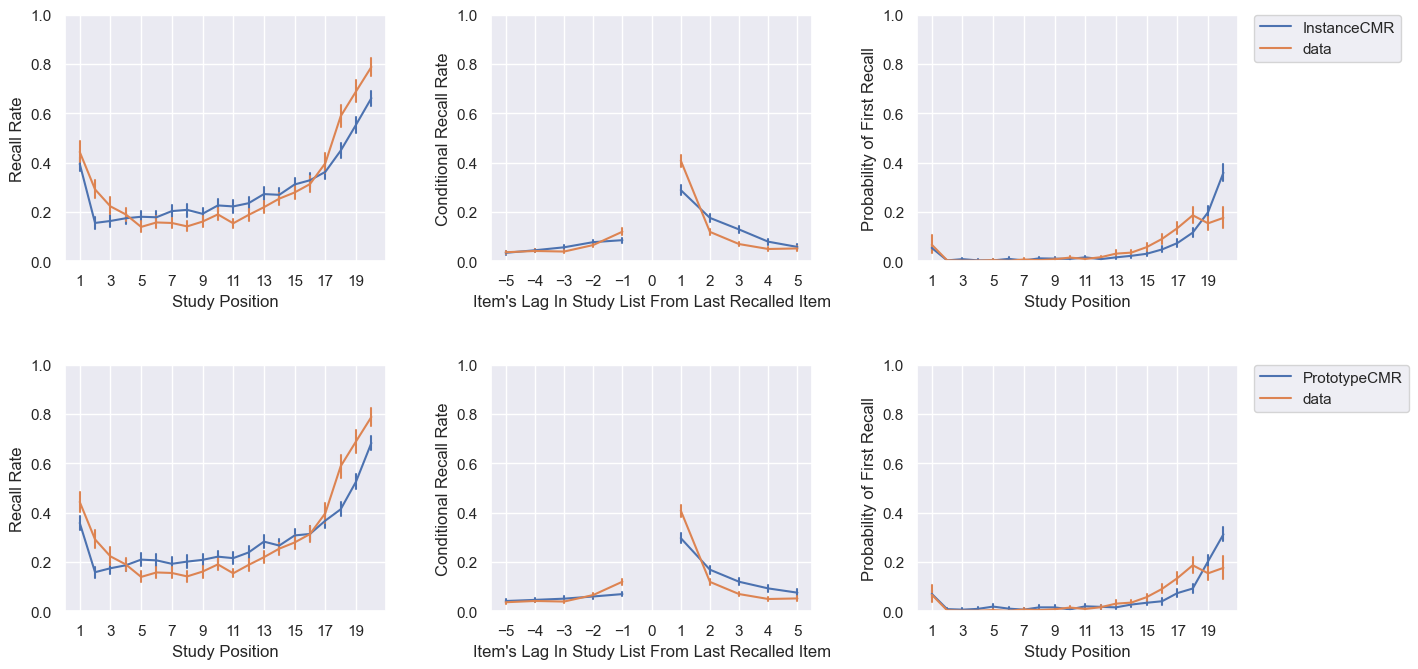

In [11]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

import matplotlib.pyplot as plt

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15/2), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, 21, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[1, 0].set_xticks(np.arange(1, 21, 2))
axes[1, 0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[0, 1].set_xticks(np.arange(-5, 6, 1))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr, x='input', y='prob', err_style='bars', ax=axes[0, 2], hue='source')
axes[0, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[0, 2].set_xticks(np.arange(1, 21, 2))
axes[0, 2].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[1, 2], hue='source')
axes[1, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[1, 2].set_xticks(np.arange(1, 21, 2))
axes[1, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('figures/overall_murdock1970.pdf', bbox_inches='tight')

![Comparison of summary statistics between each model against observed data [@murdock1970interresponse]](figures/overall_murdock1970.pdf){#fig-murdokasummary}